In [1]:
import pandas as pd

In [15]:
data=pd.read_csv("final_all.csv")

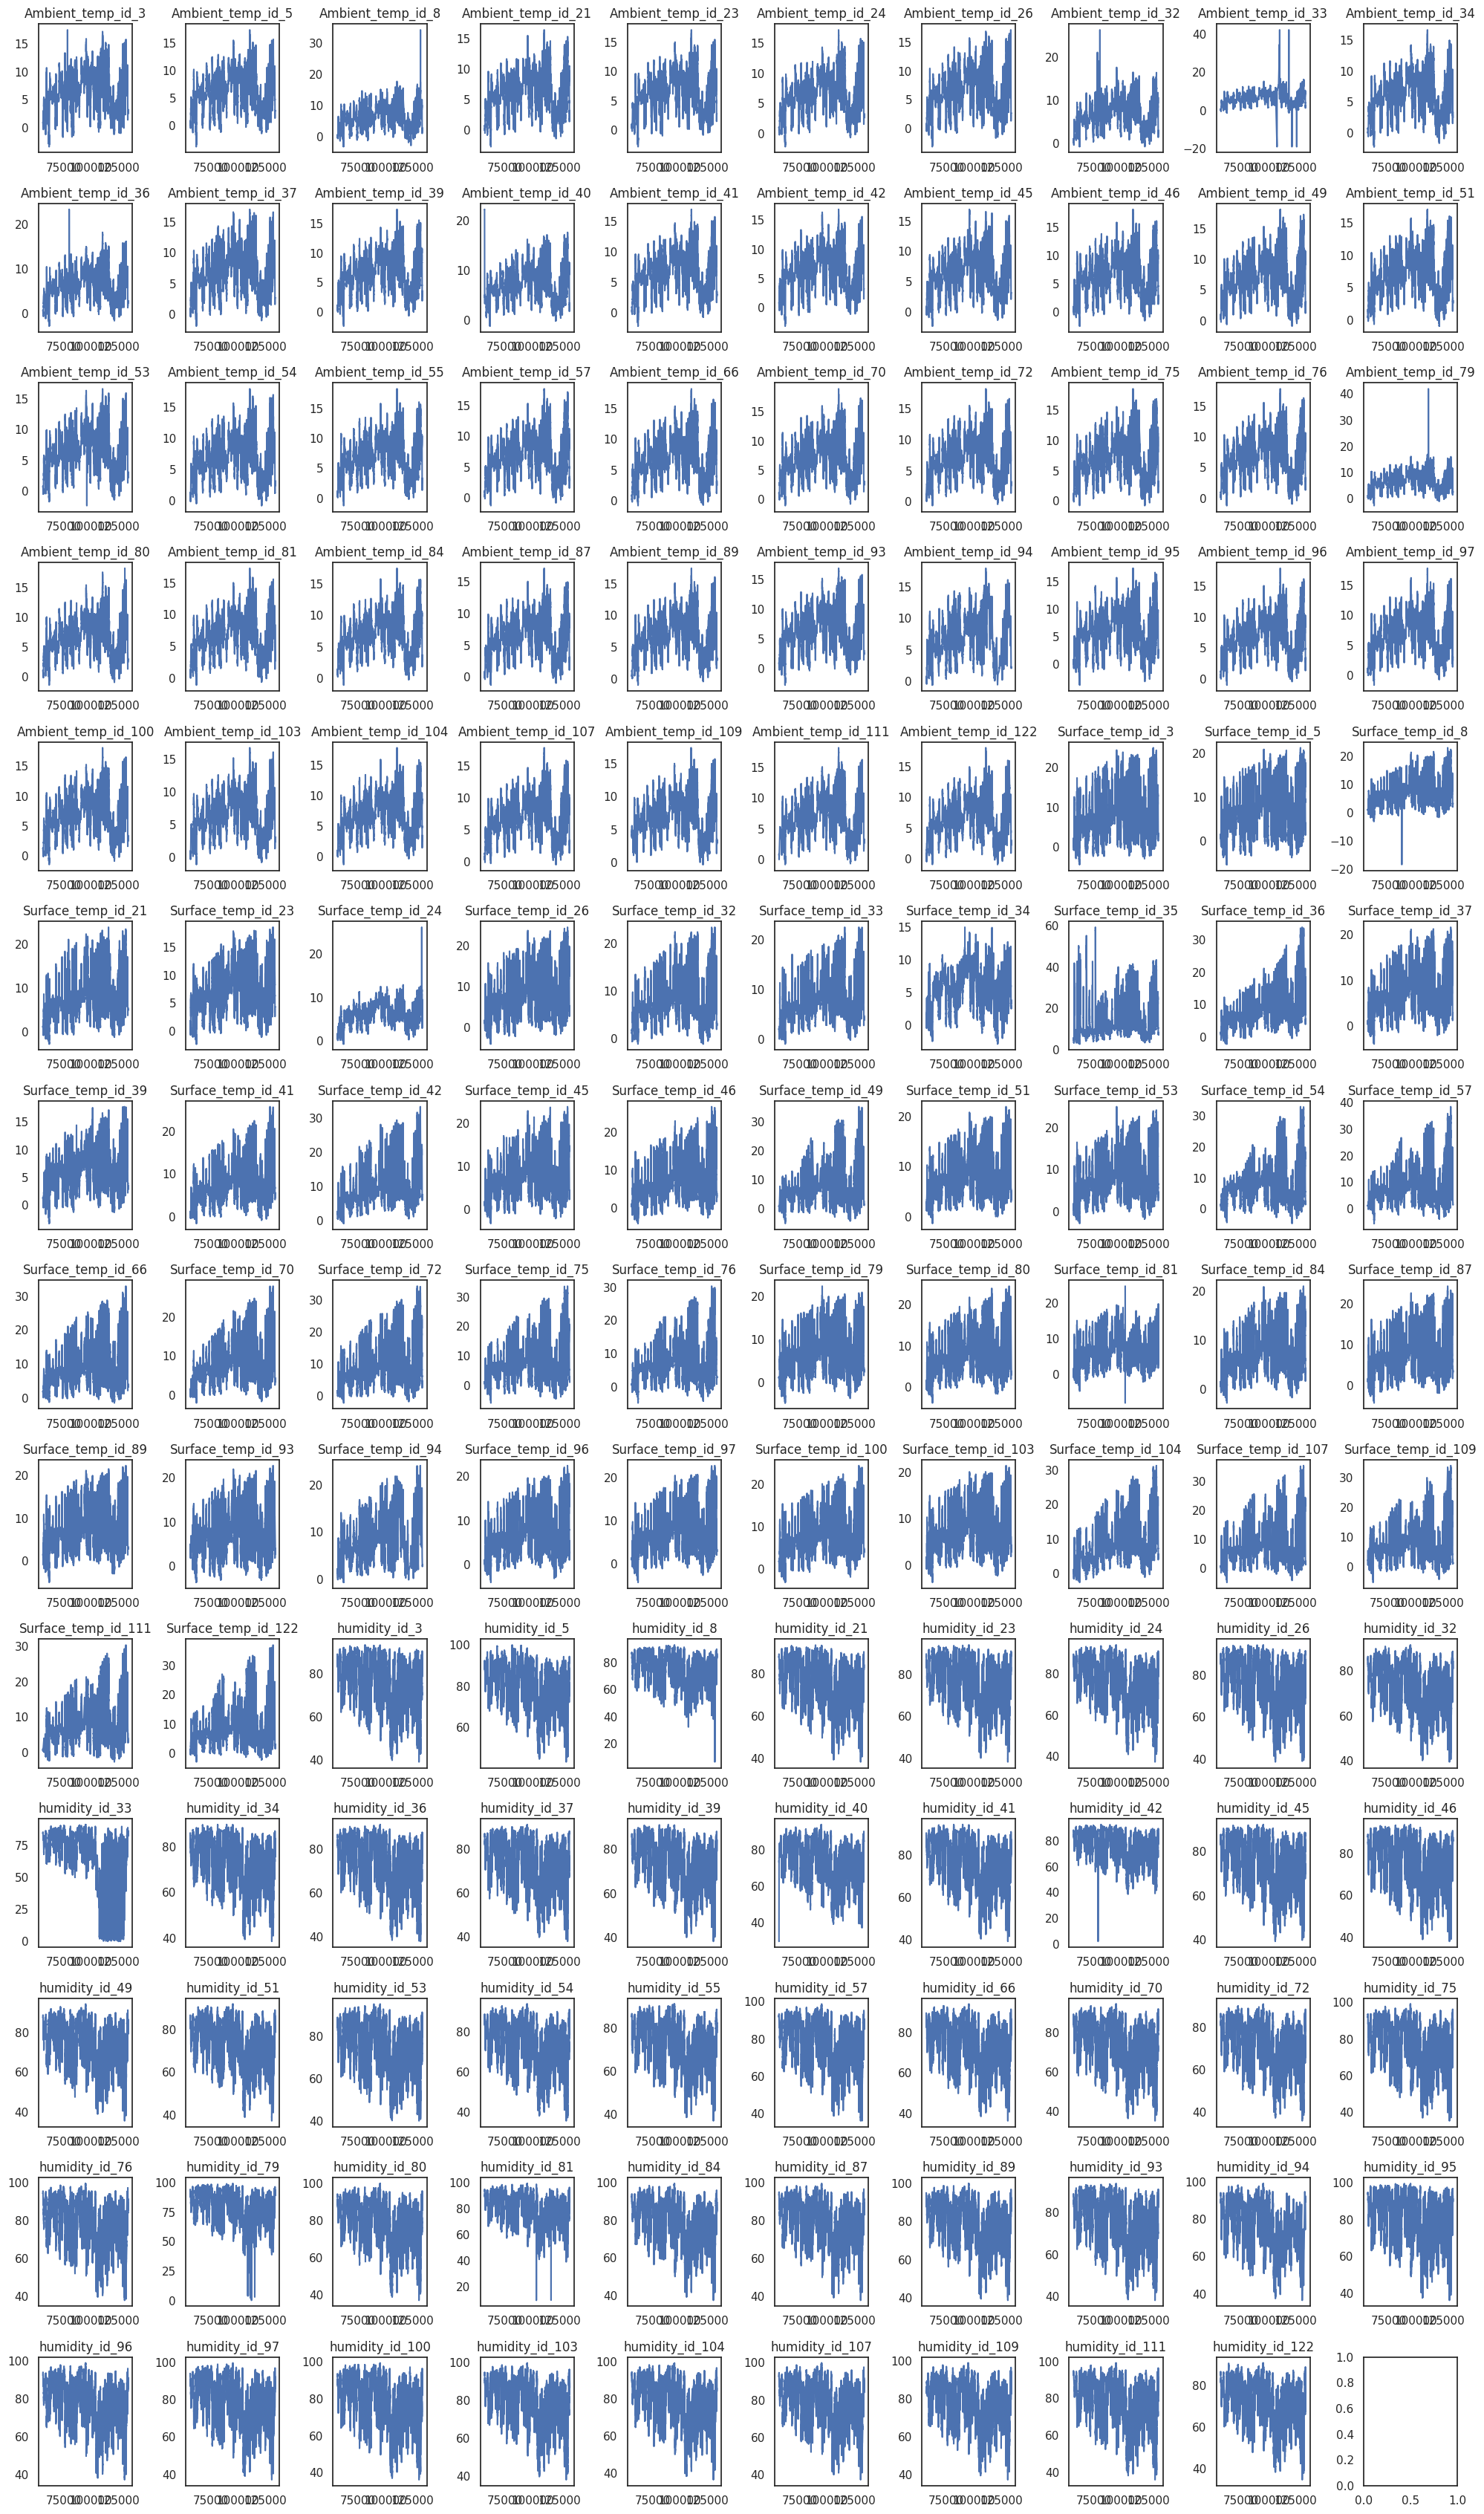

In [28]:
# Plot each column
import pandas as pd
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=14, ncols=10, figsize=(20, 34))  # Adjust grid size
axes = axes.flatten()

for i, col in enumerate(df.columns[1:]):
    df[col].plot(ax=axes[i], title=col)

# Adjust layout
plt.tight_layout()
plt.show()


In [16]:
data=data[data['datatime_min'] > '2007-02-01']

In [17]:
data=data[data['datatime_min'] < '2007-03-31']

In [18]:
data['datatime_min'] = pd.to_datetime(data['datatime_min'])

In [19]:
import pandas as pd
import numpy as np

# Sample DataFrame creation (replace this with your actual DataFrame)
# df = pd.read_csv('your_file.csv')  # Load your DataFrame
df= data

# Ensure the 'datatime_min' column is a datetime type
df['datatime_min'] = pd.to_datetime(df['datatime_min'], errors='coerce')
move=[]
# 1. Iterate through each relevant column (excluding datetime)
for column in df.columns[1:]:  # Skip the 'datatime_min' column
    nan_mask = df[column].isna()
    
    # Identify the periods of NaN values
    df['nan_period'] = nan_mask.ne(nan_mask.shift()).cumsum()
    
    # Calculate the start and end of each NaN period
    nan_periods = df[nan_mask].groupby('nan_period').agg(
        start=('datatime_min', 'min'),
        end=('datatime_min', 'max'),
        length=('datatime_min', 'count')
    ).reset_index(drop=True)
    
    # Print the results for the current column
    if not nan_periods.empty:
        print(f"Column: {column}")
        for index, row in nan_periods.iterrows():
            if row['length'] >1440 :
                move.append(column)
                print(f"  Interval {index + 1}: Start = {row['start']}, End = {row['end']}, Length = {row['length']} rows")
    else:
        print(f"Column: {column} has no NaN periods.")

Column: Ambient_temp_id_3
Column: Ambient_temp_id_4
  Interval 16: Start = 2007-02-13 15:50:00, End = 2007-02-15 18:21:00, Length = 2811 rows
Column: Ambient_temp_id_5
Column: Ambient_temp_id_8
Column: Ambient_temp_id_9
  Interval 137: Start = 2007-03-15 13:49:00, End = 2007-03-22 11:32:00, Length = 9944 rows
Column: Ambient_temp_id_21
Column: Ambient_temp_id_23
Column: Ambient_temp_id_24
Column: Ambient_temp_id_25
  Interval 94: Start = 2007-03-03 11:57:00, End = 2007-03-05 10:52:00, Length = 2816 rows
  Interval 149: Start = 2007-03-24 01:48:00, End = 2007-03-26 11:22:00, Length = 3395 rows
Column: Ambient_temp_id_26
Column: Ambient_temp_id_28
  Interval 14: Start = 2007-02-13 15:00:00, End = 2007-02-15 18:21:00, Length = 2813 rows
Column: Ambient_temp_id_29
  Interval 2: Start = 2007-02-03 05:50:00, End = 2007-02-07 11:17:00, Length = 6087 rows
  Interval 10: Start = 2007-02-13 14:59:00, End = 2007-02-15 18:20:00, Length = 2813 rows
Column: Ambient_temp_id_30
  Interval 892: Start =

In [20]:
len(move)

162

In [96]:
test_df=df_resampled.drop(columns=['nan_period'],axis=1)
numeric_cols = test_df.select_dtypes(include=['number']).columns

# Fill NaN with mean of the same hour in the same day
test_df[numeric_cols] = test_df[numeric_cols].apply(lambda col: col.fillna(col.shift(1440)))

In [21]:
df_select=data.drop(columns=move,axis=1)

In [22]:
df_select=df_select.drop(columns=['nan_period'],axis=1)

In [23]:
import pandas as pd

# Assuming you have a DataFrame named df
df = df_select.interpolate(method='linear', axis=0)  # Linear interpolation along columns (axis=0)


In [24]:
df.isna().sum(axis=0)

datatime_min             0
Ambient_temp_id_3        0
Ambient_temp_id_5        0
Ambient_temp_id_8        0
Ambient_temp_id_21       0
                      ... 
humidity_id_104          0
humidity_id_107          0
humidity_id_109       1000
humidity_id_111          0
humidity_id_122          0
Length: 140, dtype: int64

In [10]:
df_resampled.shape

(184316, 54)

In [9]:
import pandas as pd

df_resampled=df_select.copy()
# Extract hour and day
# Assuming df_resampled is already defined
# Extract hour and day
df_resampled['hour'] = df_resampled['datatime_min'].dt.hour
df_resampled['day'] = df_resampled['datatime_min'].dt.date

# Select only numeric columns (excluding 'datatime_min')
numeric_cols = df_resampled.select_dtypes(include=['number']).columns

# Fill NaN with mean of the same hour in the same day
df_resampled[numeric_cols] = df_resampled.groupby(['day', 'hour'])[numeric_cols].transform(
    lambda x: x.fillna(x.mean())
)
df_resampled[numeric_cols] = df_resampled.groupby('day')[numeric_cols].transform(lambda x: x.fillna(x.mean()))

# Drop auxiliary columns if needed
df_resampled.drop(columns=['hour', 'day'], inplace=True)

InvalidIndexError: (slice(None, None, None), slice(None, -1, None))

In [58]:
import pandas as pd
df_resampled=df_select

df_resampled['hour'] = df_resampled['datatime_min'].dt.hour
df_resampled['day'] = df_resampled['datatime_min'].dt.date

# Select only numeric columns (excluding 'datatime_min')
numeric_cols = df_resampled.select_dtypes(include=['number']).columns

# Step 1: Fill NaNs with the mean of the same hour in the same day
df_resampled[numeric_cols] = df_resampled.groupby(['day', 'hour'])[numeric_cols].transform(lambda x: x.fillna(x.mean()))

# Step 2: Fill remaining NaNs using the mean of the last 8 or next 8 hours
def fill_with_nearby_hours(group):
    for col in numeric_cols:
        for index in group.index:
            if pd.isna(group.loc[index, col]):
                last_hours_mean = group.loc[group.index < index, col].tail(8).mean()
                next_hours_mean = group.loc[group.index > index, col].head(8).mean()
                
                # Choose the best available mean
                if pd.notna(last_hours_mean) and pd.notna(next_hours_mean):
                    group.loc[index, col] = (last_hours_mean + next_hours_mean) / 2
                elif pd.notna(last_hours_mean):
                    group.loc[index, col] = last_hours_mean
                elif pd.notna(next_hours_mean):
                    group.loc[index, col] = next_hours_mean

    return group

df_resampled = df_resampled.groupby('day', group_keys=False).apply(fill_with_nearby_hours)

# **Fix:** Reset index to avoid ambiguity
df_resampled.reset_index(drop=True, inplace=True)

# Step 3: Fill any remaining NaNs with the mean of the entire day
df_resampled[numeric_cols] = df_resampled.groupby('day')[numeric_cols].transform(lambda x: x.fillna(x.mean()))

# Drop auxiliary columns
df_resampled.drop(columns=['hour', 'day'], inplace=True, errors='ignore')


/tmp/ipykernel_6615/585610585.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_resampled = df_resampled.groupby('day', group_keys=False).apply(fill_with_nearby_hours)


In [59]:
df_resampled


datatime_min  Ambient_temp_id_3  Ambient_temp_id_5  \
0     2007-02-01 00:00:00              0.965           0.840000   
1     2007-02-01 00:01:00              0.985           0.840000   
2     2007-02-01 00:02:00              0.980           0.850000   
3     2007-02-01 00:03:00              0.970           0.840000   
4     2007-02-01 00:04:00              0.975           0.835000   
...                   ...                ...                ...   
78126 2007-03-30 23:55:00              2.885           1.915046   
78127 2007-03-30 23:56:00              2.985           1.915046   
78128 2007-03-30 23:57:00              2.995           1.915046   
78129 2007-03-30 23:58:00              3.010           1.915046   
78130 2007-03-30 23:59:00              3.100           1.915046   

       Ambient_temp_id_8  Ambient_temp_id_21  Ambient_temp_id_23  \
0                  0.580            0.635000            0.975000   
1                  0.590            0.645000            0.970000   
2                  0.600            0.650000            0.965000   
3                  0.595            0.640000            0.955000   
4                  0.595            0.650000            0.960000   
...                  ...                 ...                 ...   
78126              2.300            3.054545            2.025684   
78127              2.265            3.054545            2.025684   
78128              2.305            3.054545            2.025684   
78129              2.350            3.054545            2.025684   
78130              2.410            3.054545            2.025684   

       Ambient_temp_id_24  Ambient_temp_id_26  Ambient_temp_id_32  \
0                   0.990            0.780000               0.900   
1                   0.990            0.790000               0.930   
2                   0.960            0.780000               0.930   
3                   0.955            0.795000               0.900   
4                   0.960            0.800000               0.935   
...                   ...                 ...                 ...   
78126               3.160            1.867155               2.695   
78127               3.200            1.867155               2.700   
78128               3.185            1.867155               2.700   
78129               3.140            1.867155               2.690   
78130               3.160            1.867155               2.700   

       Ambient_temp_id_33  ...  humidity_id_95  humidity_id_96  \
0                   0.660  ...       93.995500         92.3030   
1                   0.670  ...       94.019000         92.2050   
2                   0.680  ...       93.985500         92.2225   
3                   0.685  ...       93.870500         92.2600   
4                   0.680  ...       93.804000         92.3070   
...                   ...  ...             ...             ...   
78126               2.160  ...       90.873715         84.7965   
78127               2.170  ...       90.873715         83.9250   
78128               2.185  ...       90.873715         84.0070   
78129               2.235  ...       90.873715         83.9575   
78130               2.260  ...       90.873715         83.9735   

       humidity_id_97  humidity_id_100  humidity_id_103  humidity_id_104  \
0             92.5830          92.2105        93.224500          92.9905   
1             92.6610          92.2495        93.318500          93.0260   
2             92.6895          92.2375        93.358000          93.0810   
3             92.7035          92.2085        93.436500          93.0460   
4             92.5645          92.2040        93.554333          92.9770   
...               ...              ...              ...              ...   
78126         86.5950          87.0050        87.102000          85.1550   
78127         86.6755          86.9830        87.084667          84.2940   
78128         86.7880          85.8680        87.159500          84.2260   
78129    

In [18]:
import pandas as pd

# Assuming df_resampled is already defined
# Extract hour and day
# df_resampled=df_select
df_resampled['hour'] = df_resampled['datatime_min'].dt.hour
df_resampled['day'] = df_resampled['datatime_min'].dt.date

# Select only numeric columns (excluding 'datatime_min')
numeric_cols = df_resampled.select_dtypes(include=['number']).columns

#Fill NaN with mean of the same hour in the same day
# df_resampled[numeric_cols] = df_resampled.groupby(['day', 'hour'])[numeric_cols].transform(
#     lambda x: x.fillna(x.mean())
# )

# Function to fill NaNs with the mean of next 3 hours or last 3 hours
def fill_with_nearby_hours(group):
    for col in numeric_cols:
        for index in group.index:
            if pd.isna(group.loc[index, col]):
                # Calculate the mean of last 3 hours
                last_hours_mean = group.loc[group.index < index, col].tail(12).mean()
                if last_hours_mean is None :
                # Calculate the mean of next 3 hours
                #next_hours_mean = group.loc[group.index > index, col].head(3).mean()
                    last_hours_mean = group.loc[group.index > index, col].head(12).mean()
                # Fill NaN with the average of the last and next mean if they exist
                #nearby_means = [mean for mean in [last_hours_mean, next_hours_mean] if pd.notna(mean)]
    
                
                group.loc[index, col] = last_hours_mean
    return group

# Apply the function to each group of the same day
df_resampled = df_resampled.groupby('day').apply(fill_with_nearby_hours)

# Drop auxiliary columns if needed
df_resampled.drop(columns=['hour', 'day'], inplace=True)

/tmp/ipykernel_6615/482637384.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_resampled['hour'] = df_resampled['datatime_min'].dt.hour
/tmp/ipykernel_6615/482637384.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_resampled['day'] = df_resampled['datatime_min'].dt.date


ValueError: 'day' is both an index level and a column label, which is ambiguous.

In [19]:
df_resampled

datatime_min  Ambient_temp_id_3  Ambient_temp_id_5  \
day                                                                           
2007-02-01 56040  2007-02-01 00:00:00              0.965           0.840000   
           56041  2007-02-01 00:01:00              0.985           0.840000   
           56042  2007-02-01 00:02:00              0.980           0.850000   
           56043  2007-02-01 00:03:00              0.970           0.840000   
           56044  2007-02-01 00:04:00              0.975           0.835000   
...                               ...                ...                ...   
2007-03-30 134166 2007-03-30 23:55:00              2.885           1.915046   
           134167 2007-03-30 23:56:00              2.985           1.915046   
           134168 2007-03-30 23:57:00              2.995           1.915046   
           134169 2007-03-30 23:58:00              3.010           1.915046   
           134170 2007-03-30 23:59:00              3.100           1.915046   

                   Ambient_temp_id_8  Ambient_temp_id_21  Ambient_temp_id_23  \
day                                                                            
2007-02-01 56040               0.580            0.635000            0.975000   
           56041               0.590            0.645000            0.970000   
           56042               0.600            0.650000            0.965000   
           56043               0.595            0.640000            0.955000   
           56044               0.595            0.650000            0.960000   
...                              ...                 ...                 ...   
2007-03-30 134166              2.300            3.054545            2.025684   
           134167              2.265            3.054545            2.025684   
           134168              2.305            3.054545            2.025684   
           134169              2.350            3.054545            2.025684   
           134170              2.410            3.054545            2.025684   

                   Ambient_temp_id_24  Ambient_temp_id_26  Ambient_temp_id_32  \
day                                                                             
2007-02-01 56040                0.990            0.780000               0.900   
           56041                0.990            0.790000               0.930   
           56042                0.960            0.780000               0.930   
           56043                0.955            0.795000               0.900   
           56044                0.960            0.800000               0.935   
...                               ...                 ...                 ...   
2007-03-30 134166               3.160            1.867155               2.695   
           134167               3.200            1.867155               2.700   
           134168               3.185            1.867155               2.700   
           134169               3.140            1.867155               2.690   
           134170               3.160            1.867155               2.700   

                   Ambient_temp_id_33  ...  humidity_id_100  humidity_id_103  \
day                                    ...                                     
2007-02-01 56040                0.660  ...          92.2105        93.224500   
           56041                0.670  ...          92.2495        93.318500   
           56042                0.680  ...          92.2375        93.358000   
           56043                0.685  ...          92.2085        93.436500   
           56044                0.680  ...          92.2040        93.554333   
...                               ...  ...              ...              ...   
2007-03-30 134166               2.160  ...          87.0050        87.102000   
           134167               2.170  ...          86.9830        87.084667   
           134168               2.185  ...          85.8680        87.159500   
           134169     

In [88]:
df_resampled.isna().sum()

datatime_min            0
Ambient_temp_id_3       0
Ambient_temp_id_4    2365
Ambient_temp_id_5     480
Ambient_temp_id_8     480
                     ... 
humidity_id_111         0
humidity_id_121      3518
humidity_id_122         0
humidity_id_123      2545
nan_period              0
Length: 236, dtype: int64

In [ ]:
import pandas as pd

# Assuming df_resampled is already defined
# Extract hour and day
df_resampled['hour'] = df_resampled['datatime_min'].dt.hour
df_resampled['day'] = df_resampled['datatime_min'].dt.date

# Select only numeric columns (excluding 'datatime_min')
numeric_cols = df_resampled.select_dtypes(include=['number']).columns

# Fill NaN with mean of the same hour in the same day
df_resampled[numeric_cols] = df_resampled.groupby(['day', 'hour'])[numeric_cols].transform(
    lambda x: x.fillna(x.mean())
)

# Function to fill NaNs with the mean of available last 3 hours or next 3 hours
def fill_with_available_nearby_hours(group):
    for col in numeric_cols:
        for index in group.index:
            if pd.isna(group.loc[index, col]):
                # Last 3 hours (look back)
                last_hours = group.loc[group.index < index, col].dropna().tail(3)
                last_hours_mean = last_hours.mean() if not last_hours.empty else None
                
                # Next 3 hours (look forward)
                next_hours = group.loc[group.index > index, col].dropna().head(3)
                next_hours_mean = next_hours.mean() if not next_hours.empty else None
                
                # Fill NaN with the average of available means
                nearby_means = [mean for mean in [last_hours_mean, next_hours_mean] if pd.notna(mean)]
                if nearby_means:
                    group.loc[index, col] = sum(nearby_means) / len(nearby_means)
    return group

# Apply the function to each group of the same day
df_resampled = df_resampled.groupby('day').apply(fill_with_available_nearby_hours)

# Drop auxiliary columns if needed
df_resampled.drop(columns=['hour', 'day'], inplace=True)

/tmp/ipykernel_7989/4160855092.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_resampled['hour'] = df_resampled['datatime_min'].dt.hour


In [58]:
df_resampled.isna().sum().max()

3715

In [48]:
df_select.isna().sum()

datatime_min             0
Ambient_temp_id_3     2031
Ambient_temp_id_5     5103
Ambient_temp_id_8     1057
Ambient_temp_id_21    3668
                      ... 
humidity_id_104       1414
humidity_id_107        977
humidity_id_109       1431
humidity_id_111       1104
humidity_id_122        326
Length: 140, dtype: int64

In [49]:
import pandas as pd

df_resampled=df_select
# Extract hour and day
# Assuming df_resampled is already defined
# Extract hour and day
df_resampled['hour'] = df_resampled['datatime_min'].dt.hour
df_resampled['day'] = df_resampled['datatime_min'].dt.date

# Select only numeric columns (excluding 'datatime_min')
numeric_cols = df_resampled.select_dtypes(include=['number']).columns

# Fill NaN with mean of the same hour in the same day
df_resampled[numeric_cols] = df_resampled.groupby(['day', 'hour'])[numeric_cols].transform(
    lambda x: x.fillna(x.mean())
)

# Drop auxiliary columns if needed
df_resampled.drop(columns=['hour', 'day'], inplace=True)

In [27]:
import pandas as pd
import numpy as np

#df=data.drop(columns=['Surface_temp_id_43','Ambient_temp_id_69'],axis=1)


df=df_resampled



# 1. Initialize a dictionary to hold the longest NaN period for each column
longest_nan_periods = {}

# 2. Iterate through each relevant column (excluding datetime)
for column in df.columns[1:]:  # Skip the 'datatime_min' column
    nan_mask = df[column].isna()
    
    # Identify the periods of NaN values
    df['nan_period'] = nan_mask.ne(nan_mask.shift()).cumsum()
    
    # Calculate the length of each NaN period
    nan_periods = df[nan_mask].groupby('nan_period').agg(length=('datatime_min', 'count'))
    
    # Find the longest NaN period for the current column
    if not nan_periods.empty:
        longest_length = nan_periods['length'].max()
        longest_nan_periods[column] = longest_length

# Find the column with the longest NaN period
if longest_nan_periods:
    longest_column = max(longest_nan_periods, key=longest_nan_periods.get)
    longest_time_period = longest_nan_periods[longest_column]
    print(f"The longest interval of consecutive NaN values is in column '{longest_column}' with a length of: {longest_time_period} rows.")
else:
    print("No NaN periods found in any columns.")

The longest interval of consecutive NaN values is in column 'Ambient_temp_id_111' with a length of: 1320 rows.


In [88]:
import pandas as pd
import numpy as np

# Sample DataFrame creation (replace this with your actual DataFrame)
# df = pd.read_csv('your_file.csv')  # Load your DataFrame
df= df_select

# Ensure the 'datatime_min' column is a datetime type
df['datatime_min'] = pd.to_datetime(df['datatime_min'], errors='coerce')
move=[]
# 1. Iterate through each relevant column (excluding datetime)
for column in df.columns[1:]:  # Skip the 'datatime_min' column
    nan_mask = df[column].isna()
    
    # Identify the periods of NaN values
    df['nan_period'] = nan_mask.ne(nan_mask.shift()).cumsum()
    
    # Calculate the start and end of each NaN period
    nan_periods = df[nan_mask].groupby('nan_period').agg(
        start=('datatime_min', 'min'),
        end=('datatime_min', 'max'),
        length=('datatime_min', 'count')
    ).reset_index(drop=True)
    
    # Print the results for the current column
    if not nan_periods.empty:
        print(f"Column: {column}")
        for index, row in nan_periods.iterrows():

                #move.append(column)
                print(f"  Interval {index + 1}: Start = {row['start']}, End = {row['end']}, Length = {row['length']} rows")
    else:
        print(f"Column: {column} has no NaN periods.")

/tmp/ipykernel_6615/339307245.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['nan_period'] = nan_mask.ne(nan_mask.shift()).cumsum()


Column: Ambient_temp_id_3 has no NaN periods.
Column: Ambient_temp_id_5
  Interval 1: Start = 2007-02-11 03:00:00, End = 2007-02-11 03:59:00, Length = 60 rows
Column: Ambient_temp_id_8 has no NaN periods.
Column: Ambient_temp_id_21 has no NaN periods.
Column: Ambient_temp_id_23
  Interval 1: Start = 2007-02-01 17:00:00, End = 2007-02-01 23:59:00, Length = 420 rows
Column: Ambient_temp_id_24 has no NaN periods.
Column: Ambient_temp_id_26 has no NaN periods.
Column: Ambient_temp_id_32 has no NaN periods.
Column: Ambient_temp_id_33
  Interval 1: Start = 2007-03-12 18:00:00, End = 2007-03-13 14:59:00, Length = 1260 rows
  Interval 2: Start = 2007-03-13 17:00:00, End = 2007-03-14 04:59:00, Length = 720 rows
  Interval 3: Start = 2007-03-14 06:00:00, End = 2007-03-14 06:59:00, Length = 60 rows
  Interval 4: Start = 2007-03-14 19:00:00, End = 2007-03-14 23:59:00, Length = 300 rows
  Interval 5: Start = 2007-03-15 19:00:00, End = 2007-03-15 21:59:00, Length = 180 rows
  Interval 6: Start = 200

In [68]:
len(move)

162

In [69]:
df_select=data.drop(columns=move,axis=1)

In [70]:
df_select=df_select.drop(columns=['nan_period'],axis=1)

In [47]:
df_select.shape

(78131, 140)

In [28]:
data=data.fillna(method='ffill')

/tmp/ipykernel_13056/4209732964.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data=data.fillna(method='ffill')


In [32]:
data['Ambient_temp_id_64'].isna().sum()

0

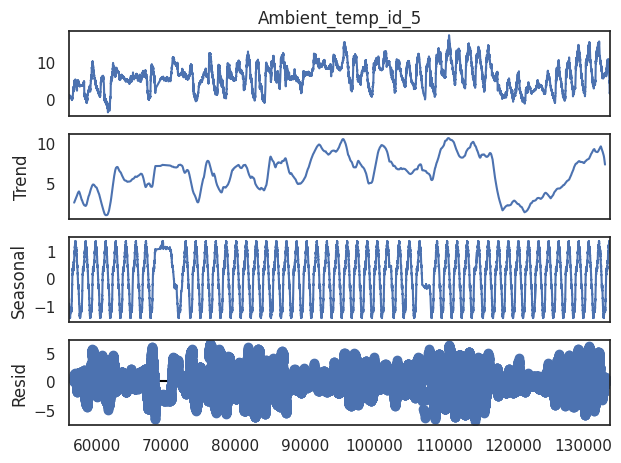

In [80]:
from statsmodels.tsa.seasonal import seasonal_decompose
data=df
# Set period based on expected seasonality (24*60 for daily cycle, 7*24*60 for weekly)
decomposition = seasonal_decompose(df['Ambient_temp_id_5'].dropna(), model='additive', period=1440)  # 1440 minutes in a day

# Plot the decomposition
decomposition.plot()
plt.show()


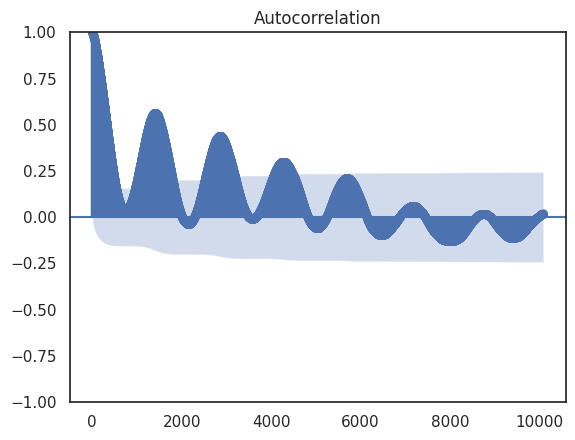

In [83]:
from statsmodels.graphics.tsaplots import plot_acf

# Drop NaN values before ACF analysis
plot_acf(df['Ambient_temp_id_5'].dropna(), lags=10080)  # 10080 minutes = 7 days
plt.show()


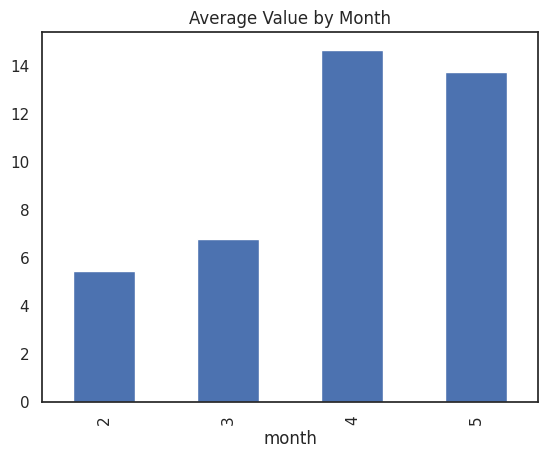

In [78]:
data['datatime_min'] = pd.to_datetime(data['datatime_min'], errors='coerce')
data['month'] = data['datatime_min'].dt.month

data.groupby('month')['Ambient_temp_id_5'].mean().plot(kind='bar')
plt.title('Average Value by Month')
plt.show()


In [72]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['Ambient_temp_id_3'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] < 0.05:
    print("The data is stationary (No seasonality).")
else:
    print("The data is non-stationary (Seasonality might exist).")


ADF Statistic: -6.999588275640813
p-value: 7.380850965305153e-10
The data is stationary (No seasonality).


In [ ]:
df_resampled['datatime_min'].dt.date

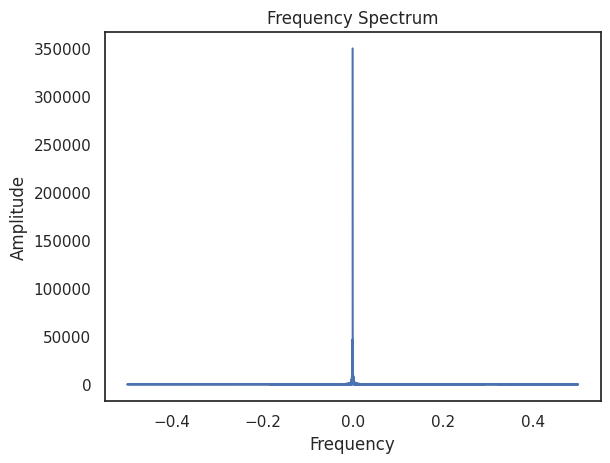

In [84]:
import numpy as np
import matplotlib.pyplot as plt
fft_vals = np.fft.fft(data['Ambient_temp_id_64'].dropna())
frequencies = np.fft.fftfreq(len(fft_vals))

plt.plot(frequencies, abs(fft_vals))
plt.title('Frequency Spectrum')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()


In [66]:
df_resampled.to_csv("one_mean.csv")

Dropped columns: ['Ambient_temp_id_5', 'Ambient_temp_id_8', 'Ambient_temp_id_21', 'Ambient_temp_id_23', 'Ambient_temp_id_24', 'Ambient_temp_id_26', 'Ambient_temp_id_32', 'Ambient_temp_id_33', 'Ambient_temp_id_34', 'Ambient_temp_id_36', 'Ambient_temp_id_37', 'Ambient_temp_id_39', 'Ambient_temp_id_40', 'Ambient_temp_id_41', 'Ambient_temp_id_42', 'Ambient_temp_id_45', 'Ambient_temp_id_46', 'Ambient_temp_id_49', 'Ambient_temp_id_51', 'Ambient_temp_id_53', 'Ambient_temp_id_54', 'Ambient_temp_id_55', 'Ambient_temp_id_57', 'Ambient_temp_id_66', 'Ambient_temp_id_70', 'Ambient_temp_id_72', 'Ambient_temp_id_75', 'Ambient_temp_id_76', 'Ambient_temp_id_79', 'Ambient_temp_id_80', 'Ambient_temp_id_81', 'Ambient_temp_id_84', 'Ambient_temp_id_87', 'Ambient_temp_id_89', 'Ambient_temp_id_93', 'Ambient_temp_id_94', 'Ambient_temp_id_95', 'Ambient_temp_id_96', 'Ambient_temp_id_97', 'Ambient_temp_id_100', 'Ambient_temp_id_103', 'Ambient_temp_id_104', 'Ambient_temp_id_107', 'Ambient_temp_id_109', 'Ambient_te

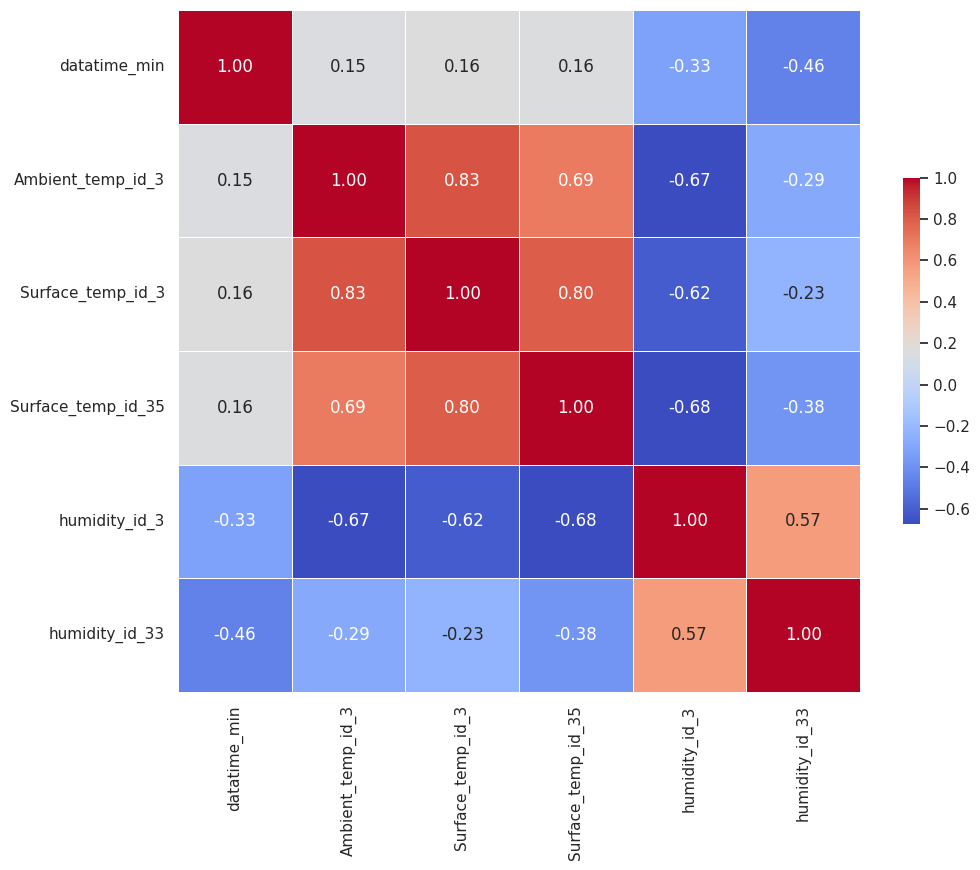

In [130]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Compute the correlation matrix
d = df_resampled # Exclude the first column if needed
corr_matrix = d.corr().abs()

# Select the upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find columns with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

# Drop highly correlated columns
d_reduced = d.drop(columns=to_drop)

print(f"Dropped columns: {to_drop}")

# Plot the reduced correlation matrix
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(d_reduced.corr(), cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5, square=True, cbar_kws={"shrink": .5})
plt.show()


In [70]:
import numpy as np

def svd_threshold(matrix, energy_threshold=0.9):
    # Perform SVD
    U, S, Vt = np.linalg.svd(matrix, full_matrices=False)
    
    # Calculate the squared singular values
    S_squared = S ** 2
    
    # Compute the total energy (sum of squared singular values)
    total_energy = np.sum(S_squared)
    
    # Compute the cumulative energy
    cumulative_energy = np.cumsum(S_squared)
    
    # Find the number of singular values needed to reach the energy threshold
    k = np.argmax(cumulative_energy >= energy_threshold * total_energy) + 1
    
    return k, cumulative_energy[k-1] / total_energy * 100


k, energy_percentage = svd_threshold(normal_data, energy_threshold=0.9)

print(f"Number of singular values to retain for 90% energy: {k}")
print(f"Percentage of energy retained: {energy_percentage}%")

Number of singular values to retain for 90% energy: 10
Percentage of energy retained: 90.43659136489028%


Maximum Singular Value: 409.78220030193955
Minimum Singular Value: 20.472076875907284
Threshold value for 90% energy: 65.37612822991767


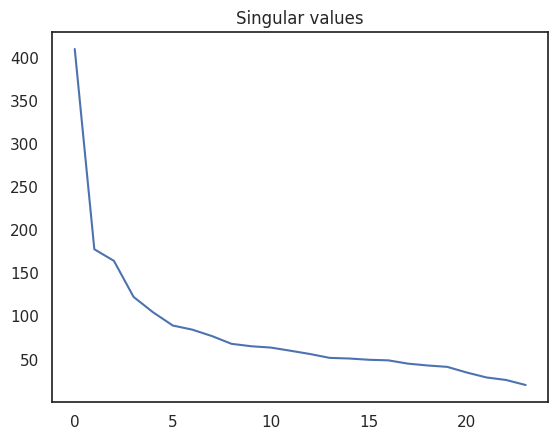

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Assuming normalized_df is your data (already normalized)
normal_data = scaler.fit_transform(d_reduced)
original_data = normal_data

# Compute the SVD with full_matrices=True
U, S, VT = svd(original_data, full_matrices=True)
# Compute the maximum singular value
max_singular_value = np.max(S)
print(f"Maximum Singular Value: {max_singular_value}")

# Compute the minimum singular value
min_singular_value = np.min(S)
print(f"Minimum Singular Value: {min_singular_value}")

# Calculate the total energy (sum of squares of singular values)
total_energy = np.sum(S**2)

# Compute the cumulative energy
cumulative_energy = np.cumsum(S**2)

# Find the threshold such that we retain 90% of the energy
threshold_energy = 0.90 * total_energy
threshold_index = np.argmax(cumulative_energy >= threshold_energy)

# Determine the threshold value (S threshold)
threshold = S[threshold_index]  # the smallest singular value that captures 90% of energy

print(f"Threshold value for 90% energy: {threshold}")

# Plot singular values
plt.plot(S)
plt.title('Singular values')
plt.savefig('singular_values.png')  # Save the plot as a PNG file
plt.show() 
# Thresholding based on the computed threshold for 90% energy
S_thresholded = np.where(S >= threshold, S, 0)

# Create the thresholded \(\Sigma\) matrix
Sigma_full = np.zeros((U.shape[0], VT.shape[0]))
Sigma_thresholded = np.zeros_like(Sigma_full)
np.fill_diagonal(Sigma_thresholded, S_thresholded)

# Reconstruct the denoised matrix
reconstructed_data = np.dot(U, np.dot(Sigma_thresholded, VT))



In [71]:
from sklearn.metrics import mean_squared_error
print(f"mse original data :{mean_squared_error(original_data,reconstructed_data)}")

mse original data :0.09563408635109723


Maximum Singular Value: 410.48540365374953
Minimum Singular Value: 28.621731084031385
Threshold value for 90% energy: 65.37612822991767


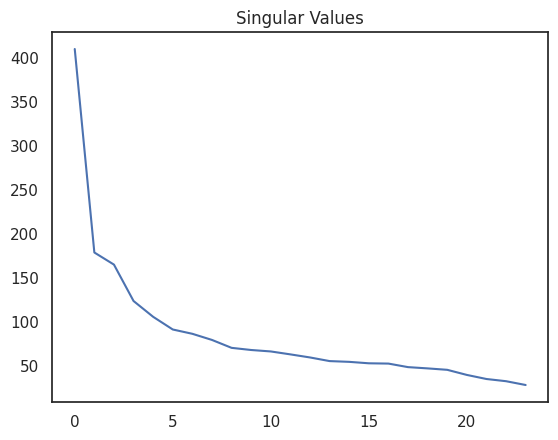

MSE (Noisy vs Original): 0.031039
MSE (Reconstructed vs Noisy): 0.098971


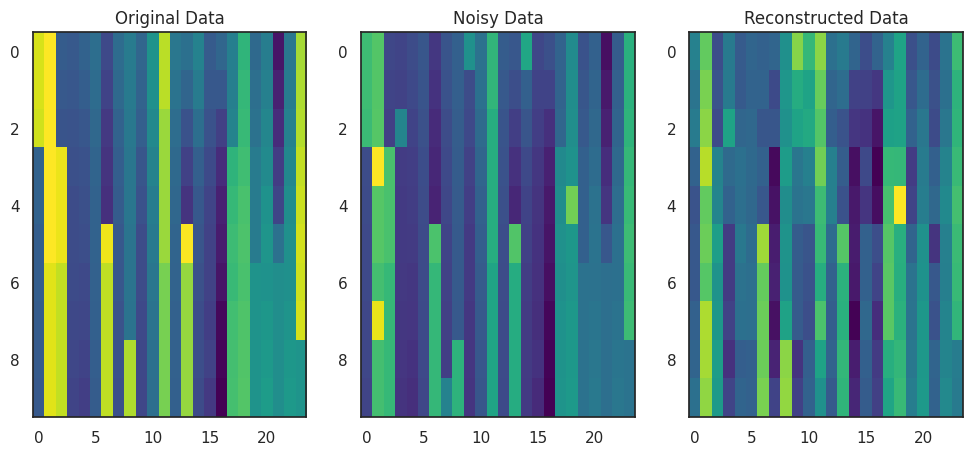

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Generate synthetic data (assuming you have d_reduced)
scaler = StandardScaler()
normal_data = scaler.fit_transform(d_reduced)
original_data = normal_data.copy()

# Add shot noise (random impulsive noise)
noise_level = 0.03  # Adjust noise intensity
shot_noise = np.random.poisson(lam=noise_level, size=original_data.shape)
noisy_data = original_data + shot_noise

# Compute SVD on the noisy data
U, S, VT = svd(noisy_data, full_matrices=True)

# Compute the maximum and minimum singular values
max_singular_value = np.max(S)
min_singular_value = np.min(S)
print(f"Maximum Singular Value: {max_singular_value}")
print(f"Minimum Singular Value: {min_singular_value}")

# Compute total energy and cumulative energy
total_energy = np.sum(S**2)
cumulative_energy = np.cumsum(S**2)

# Find the threshold that retains 90% of energy
threshold_energy = 0.90 * total_energy
threshold_index = np.argmax(cumulative_energy >= threshold_energy)
# threshold = S[threshold_index]
threshold = 65.37612822991767
print(f"Threshold value for 90% energy: {threshold}")

# Plot singular values
plt.plot(S)
plt.title('Singular Values')
plt.savefig('singular_values.png')
plt.show()

# Threshold singular values
S_thresholded = np.where(S >= threshold, S, 0)

# Create thresholded Σ matrix
Sigma_full = np.zeros((U.shape[0], VT.shape[0]))
np.fill_diagonal(Sigma_full, S_thresholded)

# Reconstruct denoised data
reconstructed_data = np.dot(U, np.dot(Sigma_full, VT))

# Compute MSE for noisy vs. denoised data
mse_noisy_original = mean_squared_error(original_data, noisy_data)
mse_reconstructed_noisy = mean_squared_error(noisy_data, reconstructed_data)

print(f"MSE (Noisy vs Original): {mse_noisy_original:.6f}")
print(f"MSE (Reconstructed vs Noisy): {mse_reconstructed_noisy:.6f}")

# Visualizing original, noisy, and reconstructed data (first few rows)
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.imshow(original_data[:10], cmap='viridis', aspect='auto')
plt.title("Original Data")

plt.subplot(1, 3, 2)
plt.imshow(noisy_data[:10], cmap='viridis', aspect='auto')
plt.title("Noisy Data")

plt.subplot(1, 3, 3)
plt.imshow(reconstructed_data[:10], cmap='viridis', aspect='auto')
plt.title("Reconstructed Data")

plt.show()


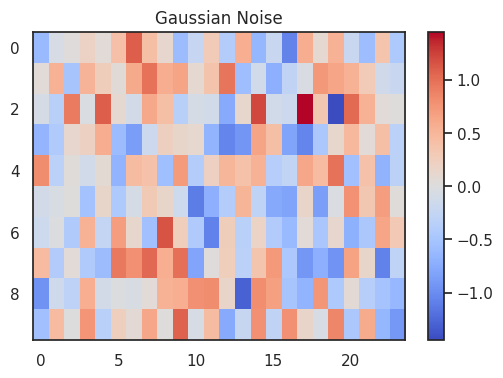

Maximum Singular Value: 415.74008771541605
Minimum Singular Value: 70.73996649441597
Threshold value for 90% energy: 65.37612822991767


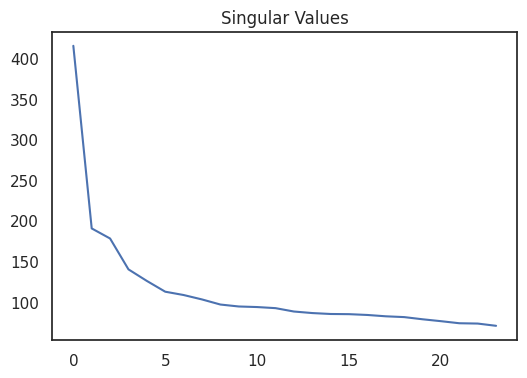

MSE (Noisy vs Original): 0.360524
MSE (Reconstructed vs Noisy): 0.360524


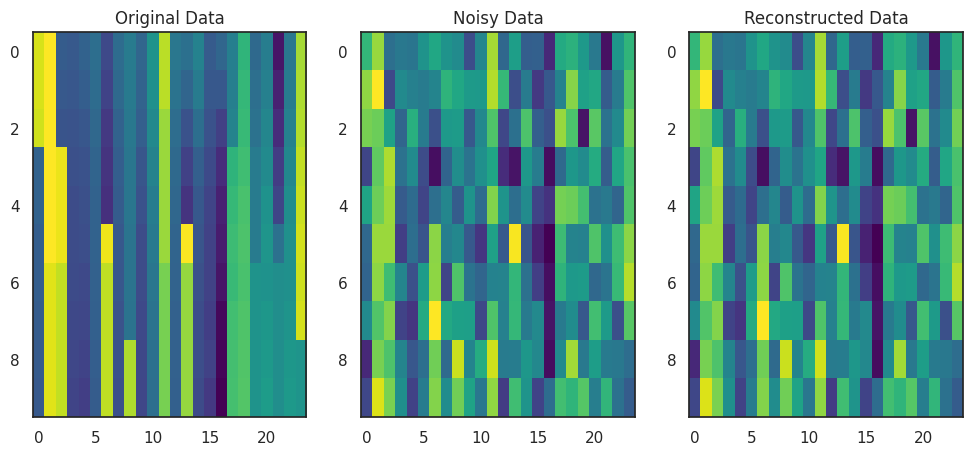

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Normalize the data
scaler = StandardScaler()
normal_data = scaler.fit_transform(d_reduced)
original_data = normal_data.copy()

# Add Gaussian noise
noise_level = 0.6 # Adjust the noise level
gaussian_noise = np.random.normal(loc=0, scale=noise_level, size=original_data.shape)
noisy_data = original_data + gaussian_noise

# Plot the noise shape
plt.figure(figsize=(6, 4))
plt.imshow(gaussian_noise[:10], cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.title("Gaussian Noise")
plt.show()

# Compute SVD on the noisy data
U, S, VT = svd(noisy_data, full_matrices=True)

# Compute max and min singular values
max_singular_value = np.max(S)
min_singular_value = np.min(S)
print(f"Maximum Singular Value: {max_singular_value}")
print(f"Minimum Singular Value: {min_singular_value}")

# Compute total energy and cumulative energy
total_energy = np.sum(S**2)
cumulative_energy = np.cumsum(S**2)

# Find the threshold that retains 90% of energy
threshold_energy = 0.90 * total_energy
threshold_index = np.argmax(cumulative_energy >= threshold_energy)
# threshold = S[threshold_index]
threshold = 65.37612822991767
print(f"Threshold value for 90% energy: {threshold}")

# Plot singular values
plt.figure(figsize=(6, 4))
plt.plot(S)
plt.title('Singular Values')
plt.show()

# Threshold singular values
S_thresholded = np.where(S >= threshold, S, 0)

# Create thresholded Σ matrix
Sigma_full = np.zeros((U.shape[0], VT.shape[0]))
np.fill_diagonal(Sigma_full, S_thresholded)

# Reconstruct denoised data
reconstructed_data = np.dot(U, np.dot(Sigma_full, VT))

# Compute MSE for noisy vs. denoised data
mse_noisy_original = mean_squared_error(original_data, 
)
mse_reconstructed_noisy = mean_squared_error(original_data, reconstructed_data)

print(f"MSE (Noisy vs Original): {mse_noisy_original:.6f}")
print(f"MSE (Reconstructed vs Noisy): {mse_reconstructed_noisy:.6f}")

# Visualizing original, noisy, and reconstructed data (first few rows)
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.imshow(original_data[:10], cmap='viridis', aspect='auto')
plt.title("Original Data")

plt.subplot(1, 3, 2)
plt.imshow(noisy_data[:10], cmap='viridis', aspect='auto')
plt.title("Noisy Data")

plt.subplot(1, 3, 3)
plt.imshow(reconstructed_data[:10], cmap='viridis', aspect='auto')
plt.title("Reconstructed Data")

plt.show()


In [25]:
import pandas as pd
df=data
# Assuming 'df' is your DataFrame
# Filter columns that start with 'Ambient_temp_id_'
ambient_temp_columns = [col for col in df.columns if col.startswith('humidity_id_')]

# Calculate the row-wise mean of these columns
df['mean_temp'] = df[ambient_temp_columns].mean(axis=1)

# Now 'df['mean_temp']' contains the mean temperature for each row


In [27]:
len(ambient_temp_columns)

78

In [28]:
ids=[3, 4, 5, 8, 9, 21, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 45, 46, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 75, 76, 79, 80, 81, 82, 84, 85, 87, 88, 89, 92, 93, 94, 95, 96, 97, 98, 100, 103, 104, 105, 106, 107, 109, 111, 121, 122, 123
]

In [41]:
data

datatime_min  Ambient_temp_id_3  Ambient_temp_id_4  \
0      2006-12-22 15:39:00                NaN           2.022222   
1      2006-12-22 15:40:00                NaN           1.940000   
2      2006-12-22 15:41:00                NaN           1.948333   
3      2006-12-22 15:42:00                NaN           1.936923   
4      2006-12-22 15:43:00                NaN           1.932500   
...                    ...                ...                ...   
184311 2007-05-07 05:18:00              8.100           9.944286   
184312 2007-05-07 05:19:00              8.195           9.961667   
184313 2007-05-07 05:20:00              8.245           9.931667   
184314 2007-05-07 05:21:00              8.295           9.901667   
184315 2007-05-07 05:22:00              8.370           9.883333   

        Ambient_temp_id_5  Ambient_temp_id_8  Ambient_temp_id_9  \
0                   1.910                NaN              1.785   
1                   1.890                NaN              1.745   
2                   1.875                NaN              1.720   
3                   1.830                NaN              1.625   
4                   1.830                NaN              1.630   
...                   ...                ...                ...   
184311              7.005              7.570              9.260   
184312              7.120              7.555              9.080   
184313              7.170              7.580              9.160   
184314              7.370              7.580              9.280   
184315              7.530              7.550              9.230   

        Ambient_temp_id_21  Ambient_temp_id_23  Ambient_temp_id_24  \
0                      NaN                 NaN                 NaN   
1                      NaN                 NaN                 NaN   
2                      NaN                 NaN                 NaN   
3                      NaN                 NaN                 NaN   
4                      NaN                 NaN                 NaN   
...                    ...                 ...                 ...   
184311               8.500                8.35               9.595   
184312               8.495                8.33               9.600   
184313               8.490                8.33               9.575   
184314               8.505                8.40               9.570   
184315               8.510                8.42               9.570   

        Ambient_temp_id_25  ...  humidity_id_104  humidity_id_105  \
0                    2.030  ...          69.8055          71.3095   
1                    2.070  ...          69.8270          71.4095   
2                    2.060  ...          69.9610          71.3810   
3                    1.995  ...          70.0695          71.2815   
4                    2.075  ...          70.1945          71.4100   
...                    ...  ...              ...              ...   
184311               7.580  ...          79.4330              NaN   
184312               7.585  ...          79.4315              NaN   
184313               7.660  ...          79.4280              NaN   
184314               7.670  ...          79.5025              NaN   
184315               7.680  ...          79.3955              NaN   

        humidity_id_106  humidity_id_107  humidity_id_109  humidity_id_111  \
0               71.4690          69.3630              NaN        70.840000   
1               71.3570          69.6950          70.3150        70.943000   
2               71.3110          69.4180          70.3305        71.070500   
3               71.2795          69.1090          70.3810        71.035500   
4               71.3815          69.3700          70.4435        71.050000   
...                 ...              ...              ...              ...   
184311              NaN          79.4100              NaN        79.210000   
184312              NaN          79.4595              NaN        79.496667   
184313              

In [26]:
df['mean_temp'].mean()

74.96106532639568

In [17]:
data['Ambient_temp_id_100'].max()

28.53

/tmp/ipykernel_32075/4198864471.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['datatime_min'] = pd.to_datetime(data['datatime_min'])


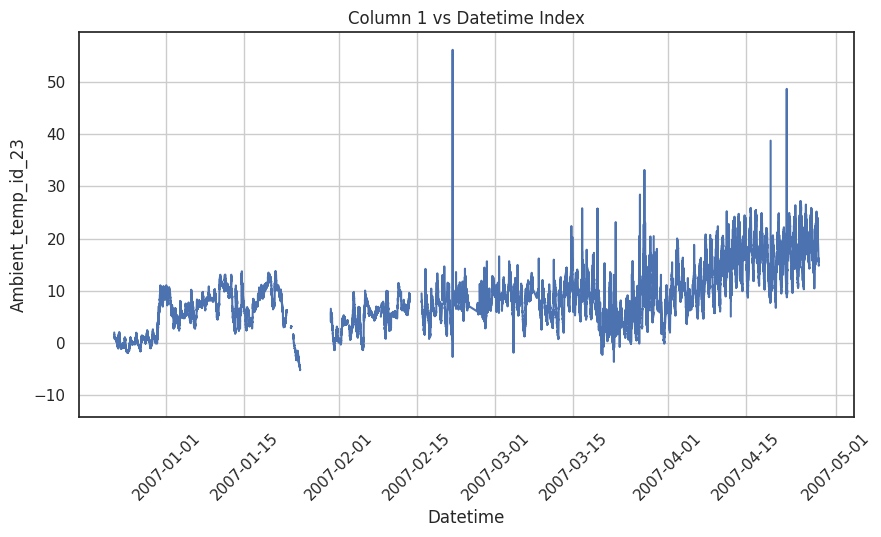

In [44]:
import matplotlib.pyplot as plt
data=df_filtered
data['datatime_min'] = pd.to_datetime(data['datatime_min'])

# Plot
plt.figure(figsize=(10, 5))
plt.plot(data['datatime_min'], data['Ambient_temp_id_4'], linestyle='-')

# Formatting
plt.xlabel('Datetime')
plt.ylabel('Ambient_temp_id_23')
plt.title('Column 1 vs Datetime Index')
plt.xticks(rotation=45)
plt.grid(True)

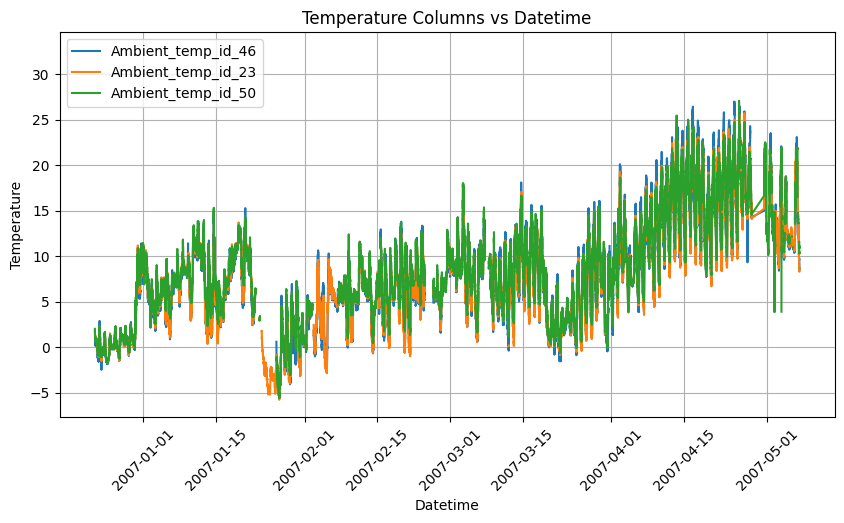

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure the datetime column is in datetime format
data['datatime_min'] = pd.to_datetime(data['datatime_min'])

# Plot
plt.figure(figsize=(10, 5))
plt.plot(data['datatime_min'], data['Ambient_temp_id_46'], linestyle='-', label='Ambient_temp_id_46')
plt.plot(data['datatime_min'], data['Ambient_temp_id_23'], linestyle='-', label='Ambient_temp_id_23')
plt.plot(data['datatime_min'], data['Ambient_temp_id_50'], linestyle='-', label='Ambient_temp_id_50')

# Formatting
plt.xlabel('Datetime')
plt.ylabel('Temperature')
plt.title('Temperature Columns vs Datetime')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()  # Add a legend to differentiate the lines

# Show plot
plt.show()


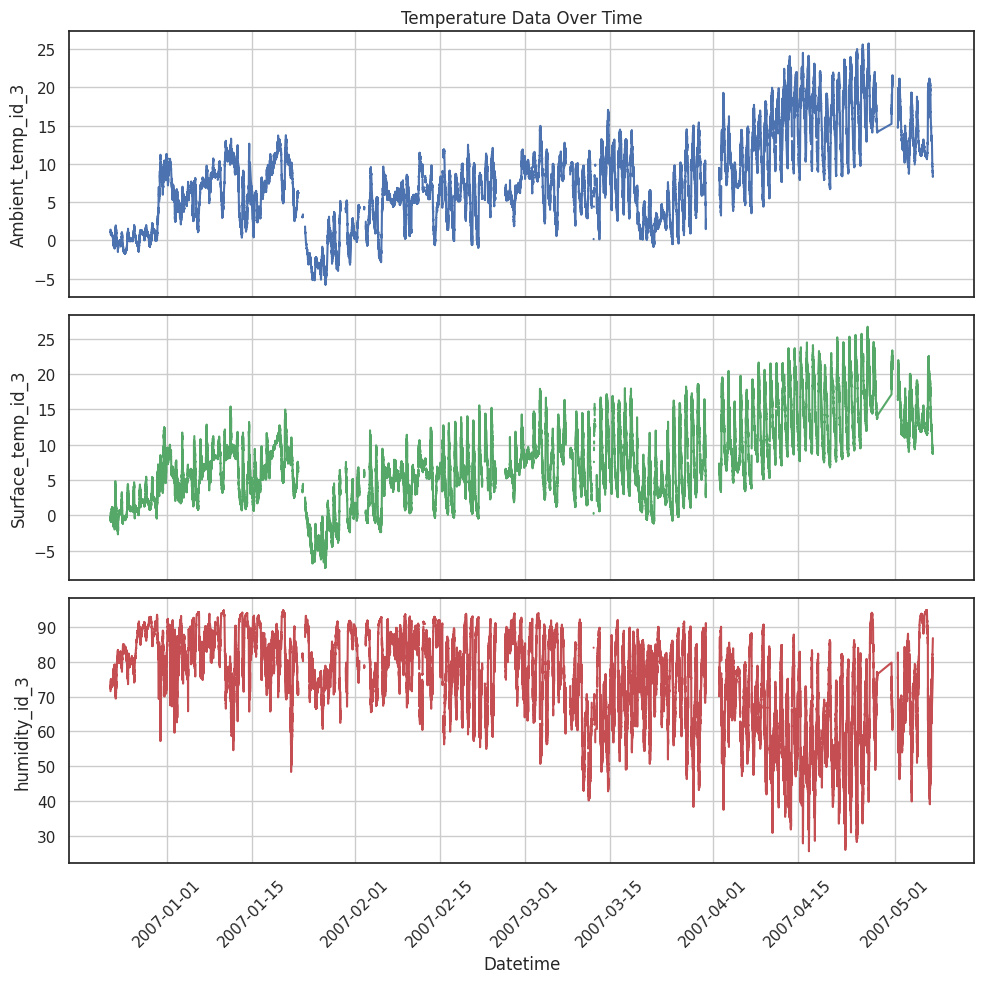

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure the datetime column is in datetime format
data['datatime_min'] = pd.to_datetime(data['datatime_min'])

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10), sharex=True)

# Plot each column in a separate subplot
axes[0].plot(data['datatime_min'], data['Ambient_temp_id_23'], linestyle='-', color='b')
axes[0].set_ylabel('Ambient_temp_id_3')
axes[0].set_title('Temperature Data Over Time')
axes[0].grid(True)

axes[1].plot(data['datatime_min'], data['Surface_temp_id_23'], linestyle='-', color='g')
axes[1].set_ylabel('Surface_temp_id_3')
axes[1].grid(True)

axes[2].plot(data['datatime_min'], data['humidity_id_23'], linestyle='-', color='r')
axes[2].set_ylabel('humidity_id_3')
axes[2].set_xlabel('Datetime')
axes[2].grid(True)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()


In [31]:
week_data

datatime_min  Ambient_temp_id_3  Ambient_temp_id_4  \
135611 2007-04-01 00:00:00                NaN           5.898333   
135612 2007-04-01 00:01:00                NaN           5.963333   
135613 2007-04-01 00:02:00                NaN           5.954286   
135614 2007-04-01 00:03:00                NaN           5.928333   
135615 2007-04-01 00:04:00                NaN           5.948333   
...                    ...                ...                ...   
175349 2007-04-30 23:56:00                NaN          12.365000   
175350 2007-04-30 23:57:00                NaN          12.360000   
175351 2007-04-30 23:58:00                NaN          12.373333   
175352 2007-04-30 23:59:00                NaN          12.391667   
175353 2007-05-01 00:00:00                NaN          12.400000   

        Ambient_temp_id_5  Ambient_temp_id_8  Ambient_temp_id_9  \
135611                NaN              5.590                NaN   
135612                NaN              5.600               5.80   
135613                NaN              5.565                NaN   
135614                NaN              5.580                NaN   
135615                NaN              5.540                NaN   
...                   ...                ...                ...   
175349                NaN             11.505              11.78   
175350                NaN             11.445              11.78   
175351                NaN             11.405              11.85   
175352                NaN             11.340              11.82   
175353                NaN             11.310              11.74   

        Ambient_temp_id_21  Ambient_temp_id_23  Ambient_temp_id_24  \
135611                 NaN                 NaN            5.905000   
135612                 NaN                 NaN            5.890000   
135613                 NaN                 NaN            5.936667   
135614                 NaN                 NaN            5.965000   
135615                 NaN                 NaN            5.960000   
...                    ...                 ...                 ...   
175349                 NaN                 NaN           12.340000   
175350                 NaN                 NaN           12.320000   
175351                 NaN                 NaN           12.300000   
175352                 NaN                 NaN           12.285000   
175353                 NaN                 NaN           12.275000   

        Ambient_temp_id_25  ...  humidity_id_103  humidity_id_104  \
135611                 NaN  ...          83.6785        81.365000   
135612                 NaN  ...          83.9205        81.243000   
135613                 NaN  ...          83.9550        81.300333   
135614                 NaN  ...          83.4380        81.367500   
135615                 NaN  ...          83.7690        81.302000   
...                    ...  ...              ...              ...   
175349              11.770  ...          94.7720        92.739500   
175350              11.725  ...          94.6520        92.962000   
175351              11.695  ...          94.5380        93.153000   
175352              11.650  ...          94.4605        93.230500   
175353              11.620  ...          94.3980        93.278000   

        humidity_id_105  humidity_id_106  humidity_id_107  humidity_id_109  \
135611          81.8660              NaN          83.1855          82.5525   
135612          81.7650              NaN          82.9230          82.5360   
135613          81.7330              NaN          82.8925          82.6650   
135614          81.7125              NaN          82.7800          82.6160   
135615          81.5520              NaN          82.5865          82.5260   
...                 ...              ...              ...              ...   
175349          94.8725              NaN              NaN              NaN   
175350          94.9220              NaN              NaN              NaN   
175351          94.9

In [49]:
week_data

datatime_min  Ambient_temp_id_3  Ambient_temp_id_4  \
87349 2007-02-24 00:00:00           8.090000           8.295000   
87350 2007-02-24 00:01:00           8.086667           8.288333   
87351 2007-02-24 00:02:00           8.040000           8.318333   
87352 2007-02-24 00:03:00           7.950000           8.203333   
87353 2007-02-24 00:04:00           7.815000           8.053333   
...                   ...                ...                ...   
87904 2007-02-25 23:56:00           5.600000           5.891667   
87905 2007-02-25 23:57:00           5.603333           5.941667   
87906 2007-02-25 23:58:00           5.620000           5.951429   
87907 2007-02-25 23:59:00           5.660000           5.931667   
87908 2007-02-26 00:00:00           5.640000           5.905000   

       Ambient_temp_id_5  Ambient_temp_id_8  Ambient_temp_id_9  \
87349              7.915              6.795              7.890   
87350              7.940              6.790              7.910   
87351              7.930              6.810              7.950   
87352              7.910              6.850              7.970   
87353              7.835              6.845              7.930   
...                  ...                ...                ...   
87904              5.485              4.780              5.430   
87905              5.485              4.770              5.400   
87906              5.480              4.770              5.375   
87907              5.505              4.780              5.420   
87908              5.495              4.790              5.470   

       Ambient_temp_id_21  Ambient_temp_id_23  Ambient_temp_id_24  \
87349               7.380               7.795               8.030   
87350               7.375               7.745               7.980   
87351               7.315               7.685               7.965   
87352               7.235               7.660               7.930   
87353               7.195               7.630               7.910   
...                   ...                 ...                 ...   
87904               5.170               5.500               5.765   
87905               5.155               5.495               5.755   
87906               5.185               5.510               5.730   
87907               5.200               5.550               5.725   
87908               5.205               5.560               5.740   

       Ambient_temp_id_25  ...  humidity_id_103  humidity_id_104  \
87349               7.900  ...        86.384000          86.3270   
87350               7.695  ...        86.420500          86.9585   
87351               7.685  ...        86.402500          87.2900   
87352               7.780  ...        86.364500          87.3945   
87353               7.725  ...        86.564667          86.8655   
...                   ...  ...              ...              ...   
87904               5.790  ...        94.099500          93.2750   
87905               5.800  ...        94.119500          93.3520   
87906               5.795  ...        94.182500          93.3345   
87907               5.775  ...        94.330500          93.4200   
87908               5.790  ...        94.405333          93.6055   

       humidity_id_105  humidity_id_106  humidity_id_107  humidity_id_109  \
87349          85.0695        82.528500          85.3670          84.5545   
87350          85.9325        82.825333          85.1305          84.3445   
87351          84.7275        83.096000          85.5565          83.8490   
87352          84.7230        82.859000          85.6195          83.9380   
87353          85.0835        82.845000          84.9750          83.8965   
...                ...              ...              ...              ...   
87904          92.4470        90.946000          92.7205          92.6350   
87905          92.3440        91.091500          92.9205          92.7045   
87906          92.2805        91.179000          93.1330          92.8875   

/tmp/ipykernel_32075/1273195051.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['datatime_min'] = pd.to_datetime(data['datatime_min'])


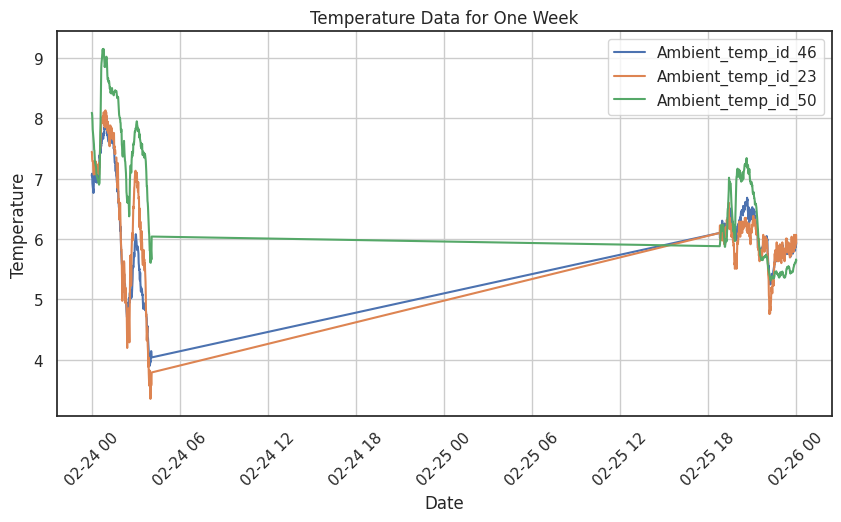

In [50]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure the datetime column is in datetime format
data['datatime_min'] = pd.to_datetime(data['datatime_min'])

# Filter data for the desired week (for example, last week)
start_date = pd.to_datetime('2007-02-24')  # Adjust to your desired week start date
end_date = pd.to_datetime('2007-02-26')    # Adjust to your desired week end date
week_data = data[(data['datatime_min'] >= start_date) & (data['datatime_min'] <= end_date)]

# Group by date (day) and calculate the mean of each day for each column
daily_data = week_data
# Plot
plt.figure(figsize=(10, 5))
plt.plot(daily_data['datatime_min'], daily_data['Surface_temp_id_123'], linestyle='-', label='Ambient_temp_id_46')
plt.plot(daily_data['datatime_min'], daily_data['Surface_temp_id_3'], linestyle='-', label='Ambient_temp_id_23')
plt.plot(daily_data['datatime_min'], daily_data['Ambient_temp_id_3'], linestyle='-', label='Ambient_temp_id_50')

# Formatting
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature Data for One Week')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

# Show plot
plt.show()


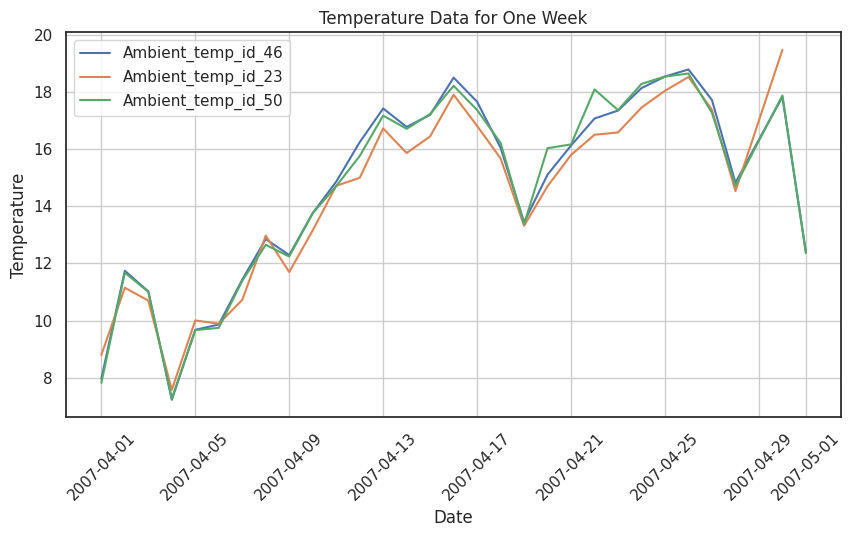

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure the datetime column is in datetime format
data['datatime_min'] = pd.to_datetime(data['datatime_min'])

# Filter data for the desired week (for example, last week)
start_date = pd.to_datetime('2007-04-1')  # Adjust to your desired week start date
end_date = pd.to_datetime('2007-05-1')    # Adjust to your desired week end date
week_data = data[(data['datatime_min'] >= start_date) & (data['datatime_min'] <= end_date)]

# Group by date (day) and calculate the mean of each day for each column
daily_data = week_data.groupby(week_data['datatime_min'].dt.date).mean()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(daily_data.index, daily_data['Ambient_temp_id_4'], linestyle='-', label='Ambient_temp_id_46')
plt.plot(daily_data.index, daily_data['Ambient_temp_id_3'], linestyle='-', label='Ambient_temp_id_23')
plt.plot(daily_data.index, daily_data['Ambient_temp_id_50'], linestyle='-', label='Ambient_temp_id_50')

# Formatting
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature Data for One Week')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

# Show plot
plt.show()


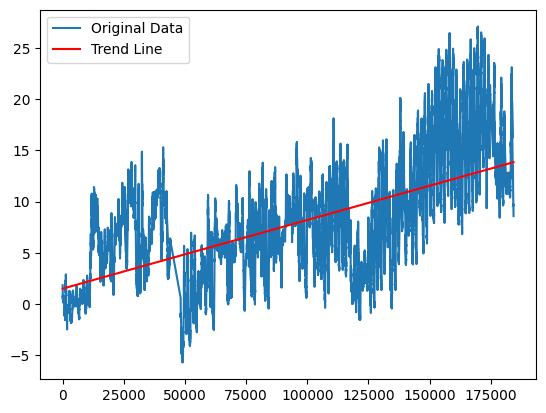

In [74]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Create time variable
time = np.arange(len(time_series_data)).reshape(-1, 1)

model = LinearRegression()
model.fit(time, time_series_data)

trend_line = model.predict(time)

plt.plot(time_series_data, label='Original Data')
plt.plot(trend_line, label='Trend Line', color='red')
plt.legend()
plt.show()


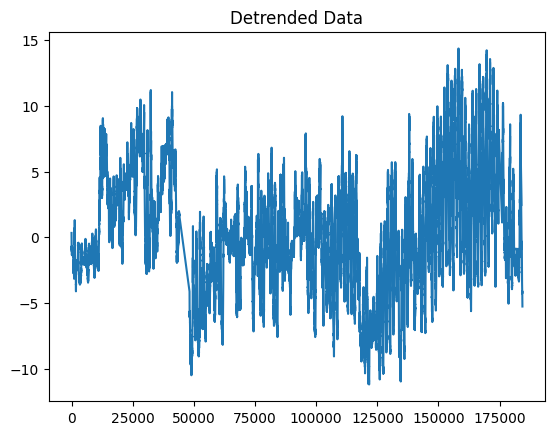

In [75]:
from scipy.signal import detrend

detrended_data = detrend(time_series_data)
plt.plot(detrended_data)
plt.title('Detrended Data')
plt.show()


<Figure size 3000x800 with 0 Axes>

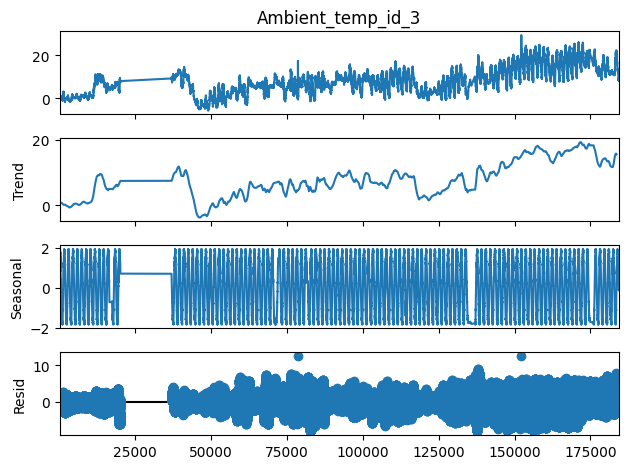

In [78]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

time_series_data = data['Ambient_temp_id_3']
# time_series_data = time_series_data.interpolate()
# time_series_data = time_series_data.fillna(time_series_data.mean())
time_series_data = time_series_data.dropna()
decomposition = seasonal_decompose(time_series_data, model='additive', period=1440)

# Set the figure size to be larger
plt.figure(figsize=(30, 8))  # Adjust the width and height as needed

decomposition.plot()
plt.show()



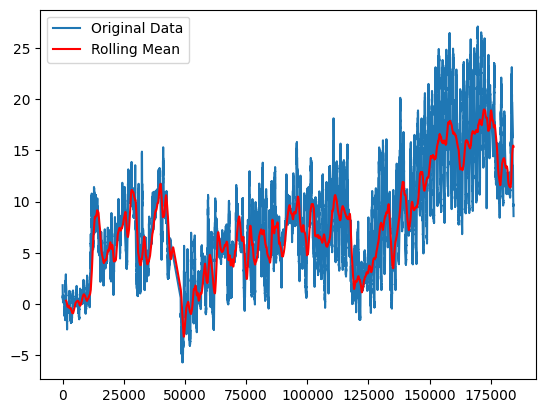

In [65]:
# Calculate a rolling mean (moving average)
rolling_mean = time_series_data.rolling(window=1400).mean()
plt.plot(time_series_data, label='Original Data')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.legend()
plt.show()


In [66]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(time_series_data)
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -7.904176372838974
p-value: 4.1087036091065635e-12


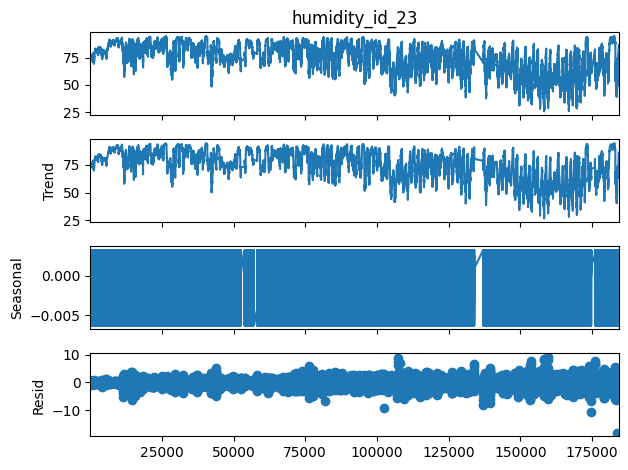

In [58]:
time_series_data = time_series_data.dropna()

decomposition = seasonal_decompose(time_series_data, model='additive', period=12)
decomposition.plot()
plt.show()



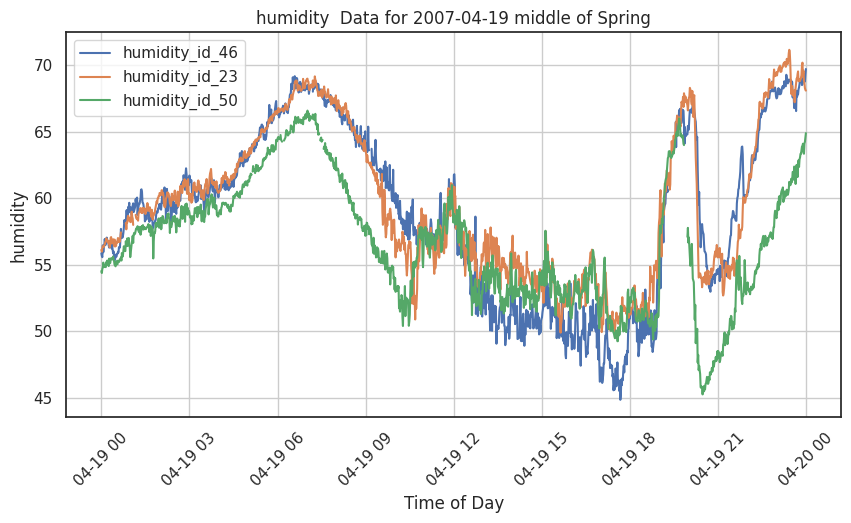

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure the datetime column is in datetime format
data['datatime_min'] = pd.to_datetime(data['datatime_min'])

# Select a specific day (e.g., 2025-02-14)
specific_day = pd.to_datetime('2007-4-19')

# Filter data for that specific day
day_data = data[data['datatime_min'].dt.date == specific_day.date()]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(day_data['datatime_min'], day_data['humidity_id_46'], linestyle='-', label='humidity_id_46')
plt.plot(day_data['datatime_min'], day_data['humidity_id_23'], linestyle='-', label='humidity_id_23')
plt.plot(day_data['datatime_min'], day_data['humidity_id_50'], linestyle='-', label='humidity_id_50')

# Formatting
plt.xlabel('Time of Day')
plt.ylabel('humidity')
plt.title(f'humidity  Data for {specific_day.date()} middle of Spring')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()

# Show plot
plt.show()


In [7]:
data['datatime_min']

0        2006-12-22 15:39:00
1        2006-12-22 15:40:00
2        2006-12-22 15:41:00
3        2006-12-22 15:42:00
4        2006-12-22 15:43:00
                 ...        
184311   2007-05-07 05:18:00
184312   2007-05-07 05:19:00
184313   2007-05-07 05:20:00
184314   2007-05-07 05:21:00
184315   2007-05-07 05:22:00
Name: datatime_min, Length: 184316, dtype: datetime64[ns]

In [10]:
df['datatime_min'].dtype

dtype('<M8[ns]')

In [12]:
print(df.dtypes)  # Check if datetime_min is datetime64
print(df.head())  # Inspect the first few rows

datatime_min         datetime64[ns]
Ambient_temp_id_3           float64
Ambient_temp_id_4           float64
Ambient_temp_id_5           float64
Ambient_temp_id_8           float64
                          ...      
humidity_id_109             float64
humidity_id_111             float64
humidity_id_121             float64
humidity_id_122             float64
humidity_id_123             float64
Length: 235, dtype: object
         datatime_min  Ambient_temp_id_3  Ambient_temp_id_4  \
0 2006-12-22 15:39:00                NaN           2.022222   
1 2006-12-22 15:40:00                NaN           1.940000   
2 2006-12-22 15:41:00                NaN           1.948333   
3 2006-12-22 15:42:00                NaN           1.936923   
4 2006-12-22 15:43:00                NaN           1.932500   

   Ambient_temp_id_5  Ambient_temp_id_8  Ambient_temp_id_9  \
0              1.910                NaN              1.785   
1              1.890                NaN              1.745   
2           

In [13]:
df

datatime_min  Ambient_temp_id_3  Ambient_temp_id_4  \
0      2006-12-22 15:39:00                NaN           2.022222   
1      2006-12-22 15:40:00                NaN           1.940000   
2      2006-12-22 15:41:00                NaN           1.948333   
3      2006-12-22 15:42:00                NaN           1.936923   
4      2006-12-22 15:43:00                NaN           1.932500   
...                    ...                ...                ...   
184311 2007-05-07 05:18:00              8.100           9.944286   
184312 2007-05-07 05:19:00              8.195           9.961667   
184313 2007-05-07 05:20:00              8.245           9.931667   
184314 2007-05-07 05:21:00              8.295           9.901667   
184315 2007-05-07 05:22:00              8.370           9.883333   

        Ambient_temp_id_5  Ambient_temp_id_8  Ambient_temp_id_9  \
0                   1.910                NaN              1.785   
1                   1.890                NaN              1.745   
2                   1.875                NaN              1.720   
3                   1.830                NaN              1.625   
4                   1.830                NaN              1.630   
...                   ...                ...                ...   
184311              7.005              7.570              9.260   
184312              7.120              7.555              9.080   
184313              7.170              7.580              9.160   
184314              7.370              7.580              9.280   
184315              7.530              7.550              9.230   

        Ambient_temp_id_21  Ambient_temp_id_23  Ambient_temp_id_24  \
0                      NaN                 NaN                 NaN   
1                      NaN                 NaN                 NaN   
2                      NaN                 NaN                 NaN   
3                      NaN                 NaN                 NaN   
4                      NaN                 NaN                 NaN   
...                    ...                 ...                 ...   
184311               8.500                8.35               9.595   
184312               8.495                8.33               9.600   
184313               8.490                8.33               9.575   
184314               8.505                8.40               9.570   
184315               8.510                8.42               9.570   

        Ambient_temp_id_25  ...  humidity_id_103  humidity_id_104  \
0                    2.030  ...          72.3520          69.8055   
1                    2.070  ...          72.5290          69.8270   
2                    2.060  ...          72.5165          69.9610   
3                    1.995  ...          72.8775          70.0695   
4                    2.075  ...          72.5520          70.1945   
...                    ...  ...              ...              ...   
184311               7.580  ...          81.7335          79.4330   
184312               7.585  ...          81.8675          79.4315   
184313               7.660  ...          82.0155          79.4280   
184314               7.670  ...          82.1195          79.5025   
184315               7.680  ...          82.3920          79.3955   

        humidity_id_105  humidity_id_106  humidity_id_107  humidity_id_109  \
0               71.3095          71.4690          69.3630              NaN   
1               71.4095          71.3570          69.6950          70.3150   
2               71.3810          71.3110          69.4180          70.3305   
3               71.2815          71.2795          69.1090          70.3810   
4               71.4100          71.3815          69.3700          70.4435   
...                 ...              ...              ...              ...   
184311              NaN              NaN          79.4100              NaN   
184312              NaN              NaN          79.4595              NaN   
184313              

In [42]:
df=data
import pandas as pd

# Rename column to correct spelling
df.rename(columns={'datatime_min': 'datetime_min'}, inplace=True)

# Ensure 'datetime_min' is in datetime format
df['datetime_min'] = pd.to_datetime(df['datetime_min'])

# Set 'datetime_min' as the index
df.set_index('datetime_min', inplace=True)

# Resample every 15 minutes and take the mean
df_resampled = df.resample('15T').mean()

print(df_resampled.head())  # Display resampled data


/tmp/ipykernel_13056/4048788747.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df.resample('15T').mean()


                     Ambient_temp_id_3  Ambient_temp_id_4  Ambient_temp_id_5  \
datetime_min                                                                   
2006-12-22 15:30:00                NaN           1.950381           1.855000   
2006-12-22 15:45:00                NaN           1.827708           1.709444   
2006-12-22 16:00:00                NaN           1.678543           1.481333   
2006-12-22 16:15:00              1.360           1.417846           1.256667   
2006-12-22 16:30:00              1.329           1.360368           1.077778   

                     Ambient_temp_id_8  Ambient_temp_id_9  Ambient_temp_id_21  \
datetime_min                                                                    
2006-12-22 15:30:00                NaN           1.687500                 NaN   
2006-12-22 15:45:00                NaN           1.518778                 NaN   
2006-12-22 16:00:00                NaN           1.353778                 NaN   
2006-12-22 16:15:00           0.90

In [31]:
df_resampled.shape

(6508, 234)

<Axes: >

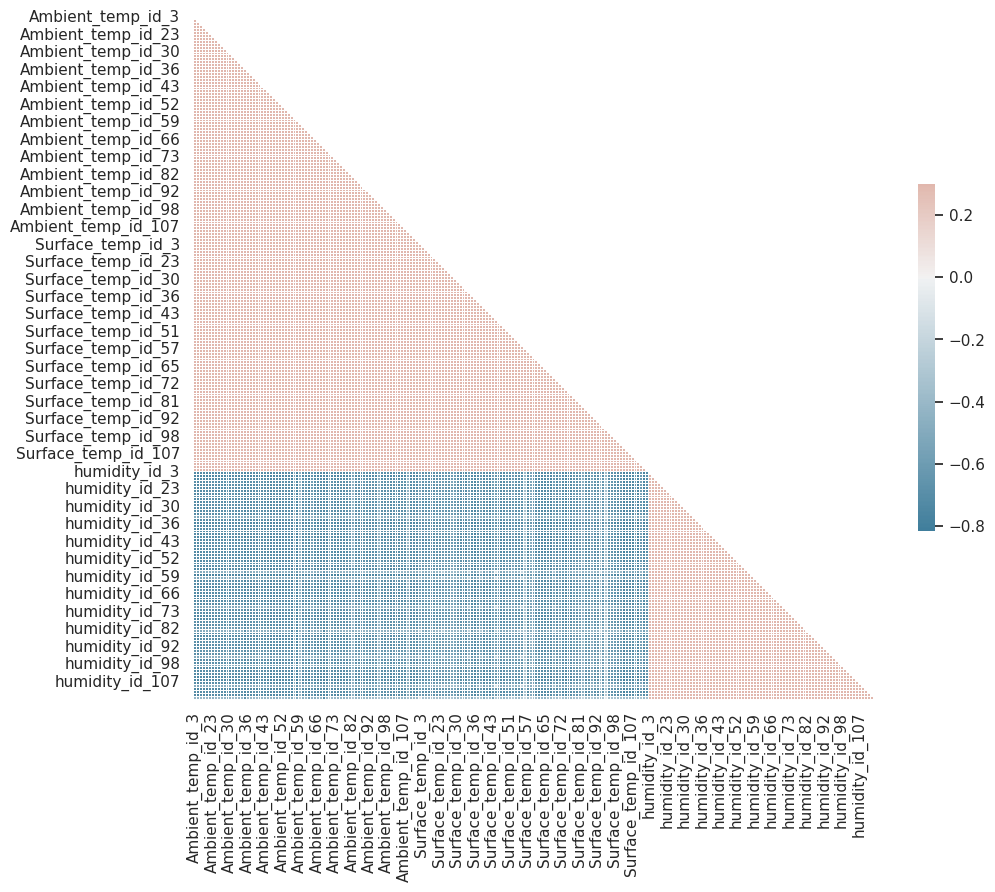

In [32]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Generate a large random dataset

d = df_resampled
# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [49]:
df_resampled.index

DatetimeIndex(['2006-12-22 15:30:00', '2006-12-22 15:45:00',
               '2006-12-22 16:00:00', '2006-12-22 16:15:00',
               '2006-12-22 16:30:00', '2006-12-22 16:45:00',
               '2006-12-22 17:00:00', '2006-12-22 17:15:00',
               '2006-12-22 17:30:00', '2006-12-22 17:45:00',
               ...
               '2007-05-07 03:00:00', '2007-05-07 03:15:00',
               '2007-05-07 03:30:00', '2007-05-07 03:45:00',
               '2007-05-07 04:00:00', '2007-05-07 04:15:00',
               '2007-05-07 04:30:00', '2007-05-07 04:45:00',
               '2007-05-07 05:00:00', '2007-05-07 05:15:00'],
              dtype='datetime64[ns]', name='datetime_min', length=13016, freq='15min')

In [38]:
import pandas as pd

# Ensure datetime index
df_resampled['hour'] = df_resampled.index.hour
df_resampled['day'] = df_resampled.index.date

# Select only numeric columns (excluding 'datatime_min')
numeric_cols = df_resampled.select_dtypes(include=['number']).columns

# Fill NaN with mean of the same hour
#df_resampled[numeric_cols] = df_resampled.groupby('hour')[numeric_cols].transform(lambda x: x.fillna(x.mean()))

# If still NaN, fill with mean of the same day
df_resampled[numeric_cols] = df_resampled.groupby('day')[numeric_cols].transform(lambda x: x.fillna(x.mean()))

# Drop auxiliary columns if needed
df_resampled.drop(columns=['hour', 'day'], inplace=True)


AttributeError: 'MultiIndex' object has no attribute 'hour'

In [29]:
df.shape

(78131, 140)

Dropped columns: ['Ambient_temp_id_5', 'Ambient_temp_id_8', 'Ambient_temp_id_21', 'Ambient_temp_id_23', 'Ambient_temp_id_24', 'Ambient_temp_id_26', 'Ambient_temp_id_32', 'Ambient_temp_id_34', 'Ambient_temp_id_36', 'Ambient_temp_id_37', 'Ambient_temp_id_39', 'Ambient_temp_id_40', 'Ambient_temp_id_41', 'Ambient_temp_id_42', 'Ambient_temp_id_45', 'Ambient_temp_id_46', 'Ambient_temp_id_49', 'Ambient_temp_id_51', 'Ambient_temp_id_53', 'Ambient_temp_id_54', 'Ambient_temp_id_55', 'Ambient_temp_id_57', 'Ambient_temp_id_66', 'Ambient_temp_id_70', 'Ambient_temp_id_72', 'Ambient_temp_id_75', 'Ambient_temp_id_76', 'Ambient_temp_id_79', 'Ambient_temp_id_80', 'Ambient_temp_id_81', 'Ambient_temp_id_84', 'Ambient_temp_id_87', 'Ambient_temp_id_89', 'Ambient_temp_id_93', 'Ambient_temp_id_94', 'Ambient_temp_id_95', 'Ambient_temp_id_96', 'Ambient_temp_id_97', 'Ambient_temp_id_100', 'Ambient_temp_id_103', 'Ambient_temp_id_104', 'Ambient_temp_id_107', 'Ambient_temp_id_109', 'Ambient_temp_id_111', 'Ambient_t

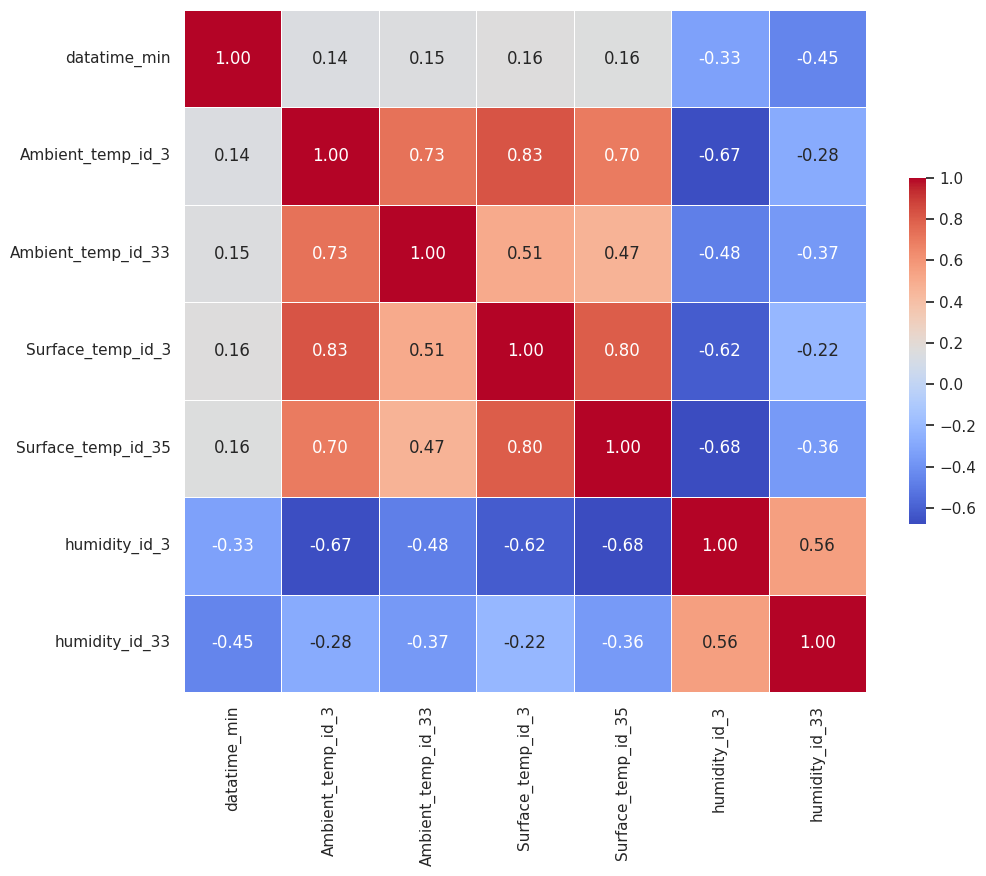

In [26]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Compute the correlation matrix
d = df  # Exclude the first column if needed
corr_matrix = d.corr().abs()

# Select the upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find columns with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

# Drop highly correlated columns
d_reduced = d.drop(columns=to_drop)

print(f"Dropped columns: {to_drop}")

# Plot the reduced correlation matrix
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(d_reduced.corr(), cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5, square=True, cbar_kws={"shrink": .5})
plt.show()
